In [26]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
tf.config.set_visible_devices([], 'GPU')

In [27]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [29]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [30]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [31]:
len(dataset)

68

In [32]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy)

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[142., 116., 117.],
        [137., 111., 112.],
        [107.,  81.,  82.],
        ...,
        [173., 155., 151.],
        [182., 164., 160.],
        [196., 178., 174.]],

       [[138., 112., 113.],
        [137., 111., 112.],
        [132., 106., 107.],
        ...,
        [175., 157., 153.],
        [177., 159., 155.],
        [185., 167., 163.]],

       [[117.,  91.,  92.],
        [112.,  86.,  87.],
        [144., 118., 119.],
        ...,
        [176., 158., 154.],
        [176., 158., 154.],
        [181., 163., 159.]],

       ...,

       [[107.,  81.,  80.],
        [146., 120., 119.],
        [126., 100.,  99.],
        ...,
        [163., 143., 142.],
        [167., 147., 146.],
        [171., 151., 150.]],

       [[115.,  89.,  88.],
        [124.,  98.,  97.],
        [160., 134., 133.],
        ...,
        [161., 141., 140.],
        [165., 145., 144.],
       

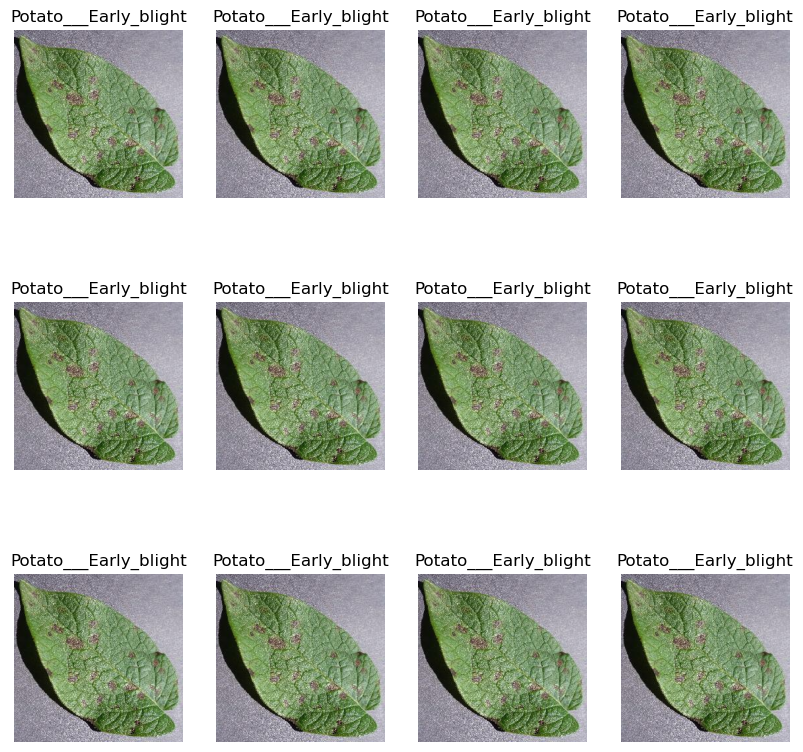

In [33]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[0].numpy().astype('uint8'))
        plt.title(class_names[label_batch[0]])
        plt.axis('off')

In [34]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [35]:
train_ds = dataset.take(54)
len(train_ds)

54

In [36]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [37]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [38]:
val_ds = test_ds.take(6)

In [39]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True, shuffle_size=10000,):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

        train_size = int(train_split*ds_size)
        val_size = int(val_split*ds_size)

        train_ds = ds.take(train_size)

        val_ds = ds.skip(train_size).take(val_size)
        test_ds = ds.skip(train_size).skip(val_size)

        return train_ds, val_ds, test_ds

In [40]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [41]:
len(train_ds)

54

In [42]:
len(val_ds)

6

In [43]:
len(test_ds)

8

In [44]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [45]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [46]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [47]:
input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
        layers.Conv2D(32,(3,3), activation='relu',input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(n_classes, activation='softmax'),
 ])

model.build(input_shape = input_shape)

In [48]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (256, 256, 256, 3)        0         
                                                                 
 sequential_4 (Sequential)   (256, 256, 256, 3)        0         
                                                                 
 conv2d_6 (Conv2D)           (256, 254, 254, 32)       896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (256, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (256, 125, 125, 64)       18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (256, 62, 62, 64)         0         
 g2D)                                                 

In [49]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [50]:
history = model.fit(
    train_ds,
    epochs = EPOCH,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 29s 511ms/step - loss: 0.9113 - accuracy: 0.4670 - val_loss: 0.8720 - val_accuracy: 0.4896
Epoch 2/50
54/54 [==============================] - 26s 491ms/step - loss: 0.7421 - accuracy: 0.6806 - val_loss: 1.0136 - val_accuracy: 0.6250
Epoch 3/50
54/54 [==============================] - 27s 494ms/step - loss: 0.4983 - accuracy: 0.7899 - val_loss: 0.4841 - val_accuracy: 0.7812
Epoch 4/50
54/54 [==============================] - 27s 496ms/step - loss: 0.3332 - accuracy: 0.8686 - val_loss: 0.4593 - val_accuracy: 0.7865
Epoch 5/50
54/54 [==============================] - 27s 491ms/step - loss: 0.2802 - accuracy: 0.8935 - val_loss: 0.2489 - val_accuracy: 0.8698
Epoch 6/50
54/54 [==============================] - 26s 489ms/step - loss: 0.2118 - accuracy: 0.9161 - val_loss: 0.2020 - val_accuracy: 0.9375
Epoch 7/50
54/54 [==============================] - 26s 489ms/step - loss: 0.1841 - accuracy: 0.9242 - val_loss: 0.1340 - val_accuracy: 0.9323

In [51]:
scores = model.evaluate(test_ds)
scores

8/8 [==============================] - 2s 130ms/step - loss: 0.1271 - accuracy: 0.9531


[0.12705835700035095, 0.953125]

In [52]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [53]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

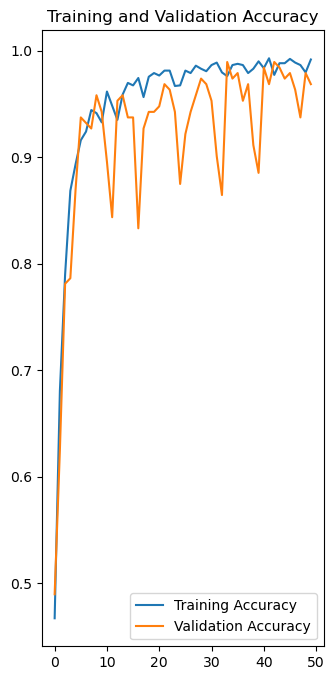

In [56]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

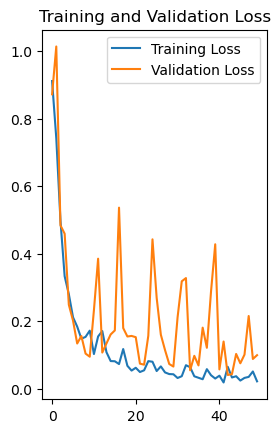

In [57]:
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 193ms/step
predicted label: Potato___Early_blight


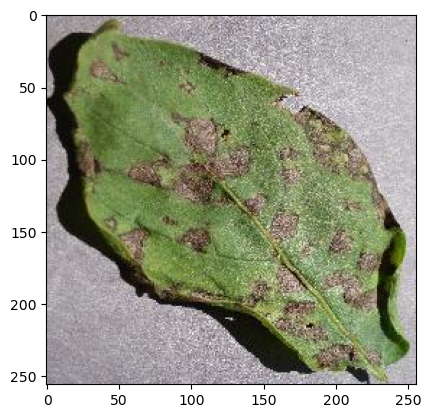

In [59]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print('first image to predict')
    plt.imshow(first_image)
    print('actual label:', class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print('predicted label:', class_names[np.argmax(batch_prediction[0])])


In [60]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)

    return predicted_class, confidence

1/1 [==============================] - 0s 16ms/step


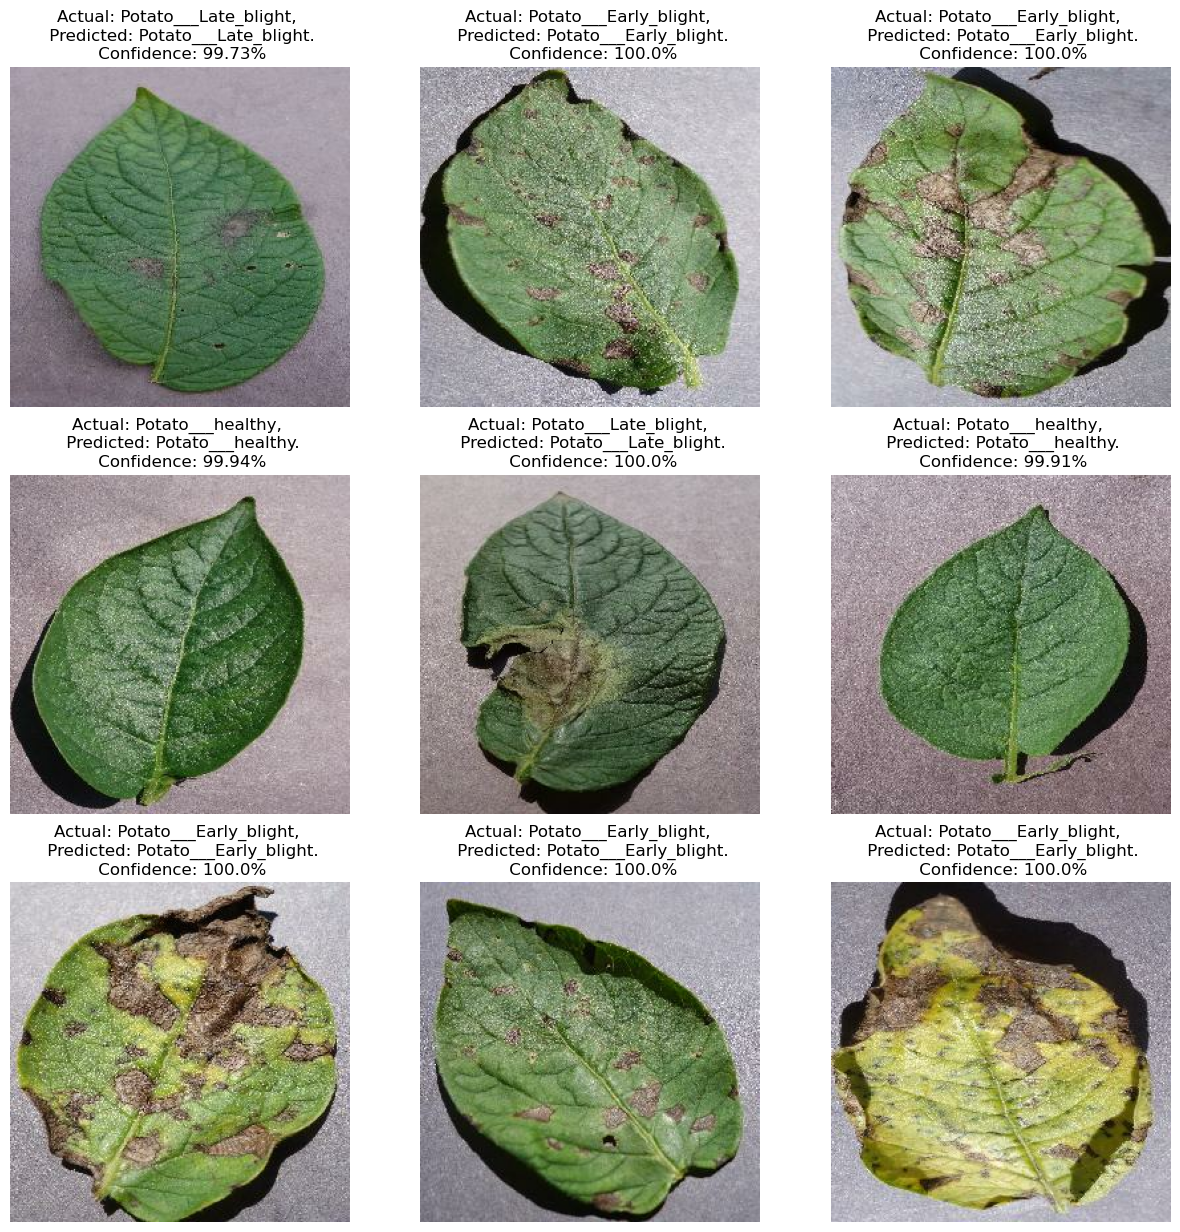

In [ ]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f'Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%')
        plt.axis('off')

In [66]:
import os

model_version = max([int(i) for i in os.listdir('/Users/bernayilmaz/Desktop/patato_disease/models') + [0]]) + 1
model.save(f'/Users/bernayilmaz/Desktop/patato_disease/models/{model_version}')

INFO:tensorflow:Assets written to: /Users/bernayilmaz/Desktop/patato_disease/models/1/assets


INFO:tensorflow:Assets written to: /Users/bernayilmaz/Desktop/patato_disease/models/1/assets
